In [1]:
%load_ext lab_black

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

## Question 1: Maximum likelihood estimation of an increasing nonnegative signal

We wish to estimate a scalar signal $x(t)$, for $t=1,2, \ldots, N$, which is known to be nonnegative and monotonically nondecreasing:

$$
0 \leq x(1) \leq x(2) \leq \cdots \leq x(N).
$$
This occurs in many practical problems. For example, $x(t)$ might be a measure of wear or deterioration, that can only get worse, or stay the same, as time  𝑡  increases. We are also given that $x(t) = 0$ for $t \le 0$.

We are given a noise-corrupted moving average of $x$, given by

$$
y(t) = \sum_{\tau=1}^k h(\tau) x(t-\tau) + v(t),\quad t=2, \ldots, N+1,
$$
where $v(t)$ are independent $\mathcal N(0,1)$ random variables.

Formulate the problem of finding the maximum likelihood estimate of $x$, given $y$, taking into account the prior assumption that $x$ is nonnegative and monotonically nondecreasing, as a convex optimization problem. Now solve a specific instance of the problem, with problem data (i.e.,  $N$, $k$, $h$, and $y$ ) given in the file `ml_estim_incr_signal_data_norng.m`. (This file contains the true signal xtrue, which of course you cannot use in creating your estimate.) Find the maximum likelihood estimate $\hat x_{\rm ml}$ , and plot it, along with the true signal. Also find and plot the maximum likelihood estimate $\hat x_{\rm ml,free}$, not taking into account the signal nonnegativity and monotonicity.

*Hint*. The function `conv` (convolution) is overloaded to work with CVX.

Which of the following statements most accurately describe the plot?

In [3]:
# create problem data
N = 100
# create an increasing input signal
xtrue = np.zeros((N, 1))
xtrue[:40] = 0.1
xtrue[49] = 2
xtrue[69:80] = 0.15
xtrue[79] = 1
xtrue = xtrue.cumsum()

# pass the increasing input through a moving-average filter and add Gaussian noise
h = np.array([1, -0.85, 0.7, -0.3])
k = len(h)
yhat = np.convolve(h, xtrue)

y = yhat[:-3] + np.array(
    eval(
        "[-0.43,-1.7,0.13,0.29,-1.1,1.2,1.2,-0.038,0.33,0.17,-0.19,0.73,-0.59,2.2,-0.14,0.11,1.1,0.059,-0.096,-0.83,0.29,-1.3,0.71,1.6,-0.69,0.86,1.3,-1.6,-1.4,0.57,-0.4,0.69,0.82,0.71,1.3,0.67,1.2,-1.2,-0.02,-0.16,-1.6,0.26,-1.1,1.4,-0.81,0.53,0.22,-0.92,-2.2,-0.059,-1,0.61,0.51,1.7,0.59,-0.64,0.38,-1,-0.02,-0.048,4.3e-05,-0.32,1.1,-1.9,0.43,0.9,0.73,0.58,0.04,0.68,0.57,-0.26,-0.38,-0.3,-1.5,-0.23,0.12,0.31,1.4,-0.35,0.62,0.8,0.94,-0.99,0.21,0.24,-1,-0.74,1.1,-0.13,0.39,0.088,-0.64,-0.56,0.44,-0.95,0.78,0.57,-0.82,-0.27]"
    )
)

In [4]:
x_ml = cp.Variable(N)
y_ml = cp.conv(h, x_ml)[:-3, 0]
constraints = [x_ml[0] >= 0] + [x1 <= x2 for x1, x2 in zip(x_ml, x_ml[1:])]
obj = cp.Minimize(cp.sum_squares(y - y_ml))
prob = cp.Problem(obj, constraints)

In [5]:
prob.solve()

58.99963475072767

In [6]:
x_free = cp.Variable(N)
y_free = cp.conv(h, x_free)[:-3, 0]
obj_free = cp.Minimize(cp.sum_squares(y - y_free))
prob_free = cp.Problem(obj_free)
prob_free.solve()

9.602767219195726e-41

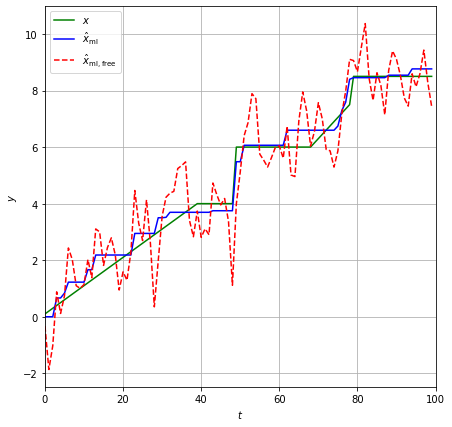

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.plot(xtrue, c="g", label="$x$")
ax.plot(x_ml.value, c="b", label=r"$\hat x_{\rm ml}$")
ax.plot(x_free.value, "r--", label=r"$\hat x_{\rm ml,free}$")
ax.set_ylabel("$y$")
ax.set_xlabel("$t$")
ax.set_xlim(0, N)
ax.legend()
ax.grid()

*Conclusion:* The maximum deviation of $\hat x_{\rm ml}$ from the true signal, $x$, is smaller than that of $\hat x_{\rm ml,free}$.

## Question 2: Worst-case probability of loss

Two investments are made, with random returns $R_1$ and $R_2$. The total return for the two investments is $R_1+R_2$, and the probability of a loss (including breaking even, i.e., $R_1+R_2=0$) is  $p^\mathrm{loss} = \mathbf{prob} (R_1+R_2 \leq 0)$. The goal is to find the worst-case (i.e., maximum possible) value of $p^\mathrm{loss}$, consistent with the following information. Both $R_1$ and $R_2$ have Gaussian marginal distributions, with known means $\mu_1$ and $\mu_2$
and known standard deviations $\sigma_1$ and $\sigma_2$. In addition, it is known that $R_1$ and $R_2$ are correlated with correlation coefficient $\rho$ , i.e.,

$$
\mathbf{E} (R_1-\mu_1) (R_2-\mu_2)  = \rho \sigma_1 \sigma_2.
$$

Your job is to find the worst-case $p^\mathrm{loss}$ over any joint distribution of $R_1$ and $R_2$ consistent with the given marginals and correlation coefficient.

We will consider the specific case with data

$$
\mu_1 = 8, \quad \mu_2 = 20, \quad \sigma_1 = 6, \quad \sigma_2 = 17.5,\quad \rho = -0.25.
$$

We can compare the results to the case when $R_1$ and $R_2$ are jointly Gaussian. In this case we have

$$
R_1+R_2 \sim \mathcal N(\mu_1+\mu_2,\sigma_1^2+\sigma_2^2+2 \rho \sigma_1\sigma_2),
$$

which for the data given above gives $p^\mathrm{loss}=0.050$. Your job is to see how much larger $p^\mathrm{loss}$ can possibly be.

This is an infinite-dimensional optimization problem, since you must maximize $p^\mathrm{loss}$ over an infinite-dimensional set of joint distributions. To (approximately) solve it, we discretize the values that $R_1$ and $R_2$ can take on, to $n=100$ values $r_1,\ldots, r_n$, uniformly spaced from $r_1=-30$ to $r_n=+70$. We use the discretized marginals $p^{(1)}$ and $p^{(2)}$ for $R_1$ and $R_2$, given by

$$
p^{(k)}_i =\mathbf{prob}(R_k = r_i) =\frac{ \exp \left(-(r_i-\mu_k)^2/(2 \sigma_k^2) \right)}{\sum_{j=1}^n  \exp \left( -(r_j-\mu_k)^2/(2 \sigma_k^2) \right)},
$$

Formulate the (discretized) problem as a convex optimization problem, and solve it. What is the maximum value of $p^\mathrm{loss}$?



In [8]:
def prob(r, mu, sigma):
    numerator = np.exp(-((r - mu) ** 2) / (2 * sigma ** 2))
    denominator = numerator.sum()
    return numerator / denominator

In [9]:
mu_1 = 8
mu_2 = 20
sigma_1 = 6
sigma_2 = 17.5
rho = -0.25

n = 100
r = np.linspace(-30, 70, n)
prob_1 = prob(r, mu_1, sigma_1)
prob_2 = prob(r, mu_2, sigma_2)

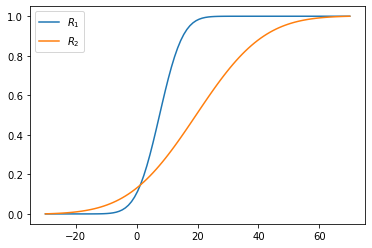

In [10]:
plt.plot(r, prob_1.cumsum(), label="$R_1$")
plt.plot(r, prob_2.cumsum(), label="$R_2$")
_ = plt.legend()

## Solution
First, let's convert the data into moment constraints where we define $P = \mathbf{prob} (R_1=r_i,R_2 = r_j)$:

$$
\begin{align*}
P \,\mathbf{1} &= p^{(1)} \\
P^T \mathbf{1} &= p^{(2)} \\
\mathbf{E} (R_1 R_2) &= r^T P\, r = \rho \sigma_1 \sigma_2 + \mu_1 \mu_2
\end{align*}
$$

In [11]:
P = cp.Variable((n, n), nonneg=True)
I = np.ones((n, 1))

constraints = [
    P @ I == np.matrix(prob_1).T,
    P.T @ I == np.matrix(prob_2).T,
    np.matrix(r) @ P @ np.matrix(r).T == rho * sigma_1 * sigma_2 + mu_1 * mu_2,
]
R = np.array([[r[i] + r[j] for j in range(n)] for i in range(n)])
obj = cp.Maximize(cp.sum(P[R <= 0]))
prob = cp.Problem(obj, constraints)

In [12]:
prob.solve()

0.19203645969871805

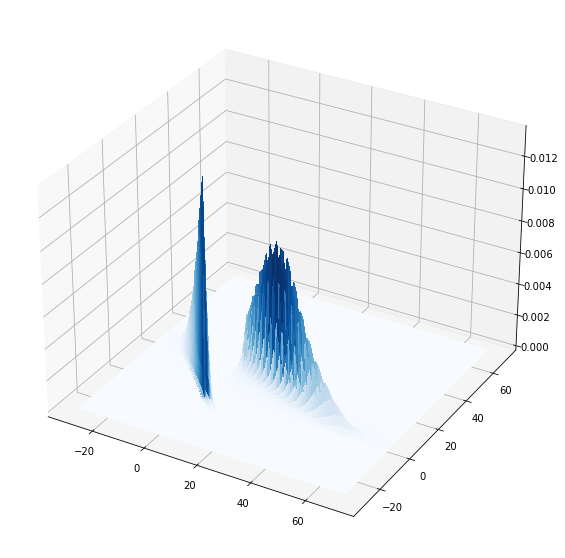

In [13]:
x, y, z = *np.meshgrid(r, r), P.value

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")
_ = ax.plot_surface(
    x, y, z, cmap=plt.cm.Blues, rstride=1, cstride=1, linewidth=0, antialiased=False
)

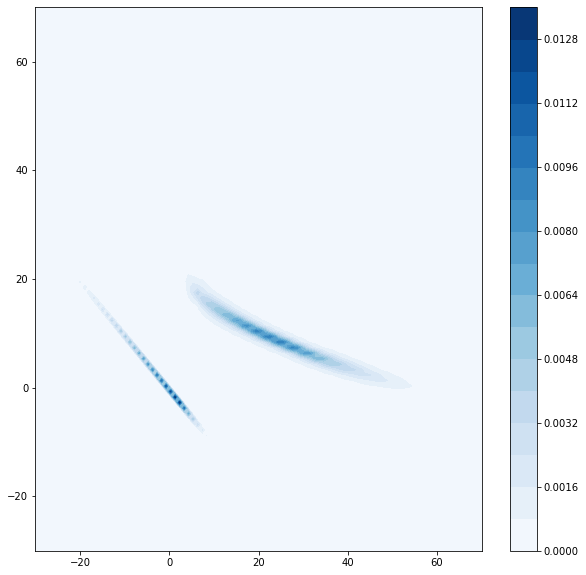

In [14]:
plt.figure(figsize=(10, 10))
plt.contourf(x, y, z, levels=20, cmap=plt.cm.Blues)
_ = plt.colorbar()